Практическое задание:

1. Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php).
2. Сделать обзорный анализ выбранного датасета.
3. Сделать feature engineering.
4. Обучить любой классификатор (какой вам нравится).
5. Разобраться с SHAP и построить важности признаков для:
всего тестового набора данных (summary_plot - дать интерпретацию),
для топ 10%,
для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат.

In [37]:
pip install shap

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numba in c:\users\79609\anaconda3\lib\site-packages (from shap) (0.51.2)



In [38]:
import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

import shap
shap.initjs()

import xgboost as xgb

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
import warnings
warnings.filterwarnings('ignore')

Для анализа воспользуемся данным набором данных- https://archive.ics.uci.edu/ml/datasets/Adult .

In [40]:
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
            'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

target = 'income'

df = pd.read_csv('adult.data', sep=',', index_col=False, names = features + [target])

In [41]:
df.shape

(32561, 15)

In [42]:
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Проверим количество пропусков.

In [43]:
pd.DataFrame([df.isna().sum(), df.isnull().sum()], index={'na', 'null'})

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
na,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Визуализируем некоторые признаки.

<AxesSubplot:xlabel='age', ylabel='count'>

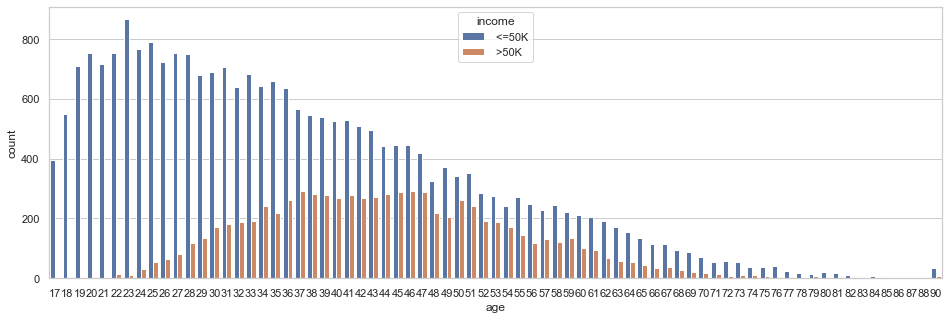

In [44]:
plt.figure(figsize=(16, 5))
sns.countplot(data=df, x='age', hue='income')

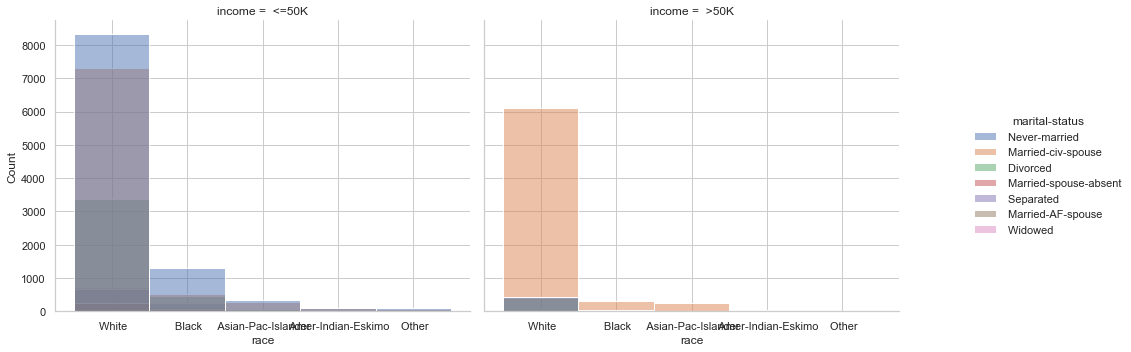

In [45]:
g = sns.displot(data=df, x="race", hue='marital-status', col='income', kind='hist')
g.fig.set_size_inches(16, 5)

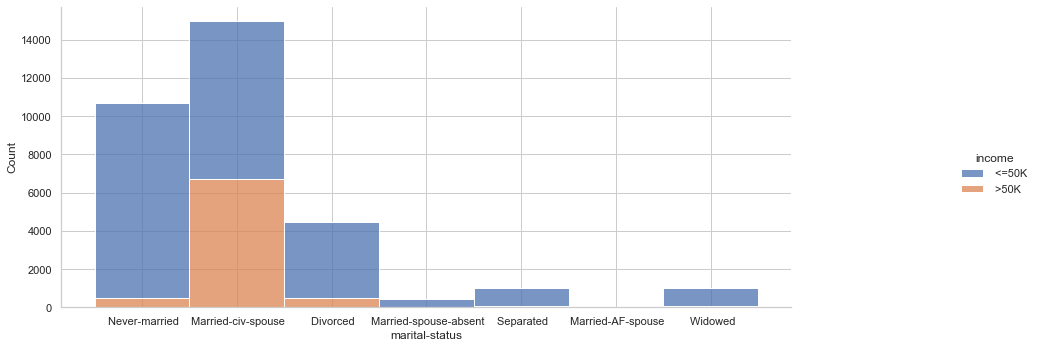

In [46]:
sns.set_theme(style="whitegrid")
b = sns.displot(data=df,
                x="marital-status",
                multiple='stack',
                hue='income')
b.fig.set_size_inches(16, 5)

Преобразуем значения целевой переменной 'income' к значениям 0 или 1.

In [47]:
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})

Воспользуемся One-Hot Encoding для кодирования признаков, кроме целевой переменной.

In [48]:
X = pd.get_dummies(df.drop('income', axis=1))
y = df['income']

Разделим датасет на обучающую и тестовую выборки.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Обучим модель при помощи XGBoost.

In [50]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

[23:21:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [51]:
def evaluate_results(y_test, y_predict):

    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0))

In [52]:
evaluate_results(y_test, y_predict)

Classification results:
f1: 70.62%
roc: 79.77%
recall: 66.08%
precision: 75.84%


Применим SHAP.

In [53]:
model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X, label=y), 100)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

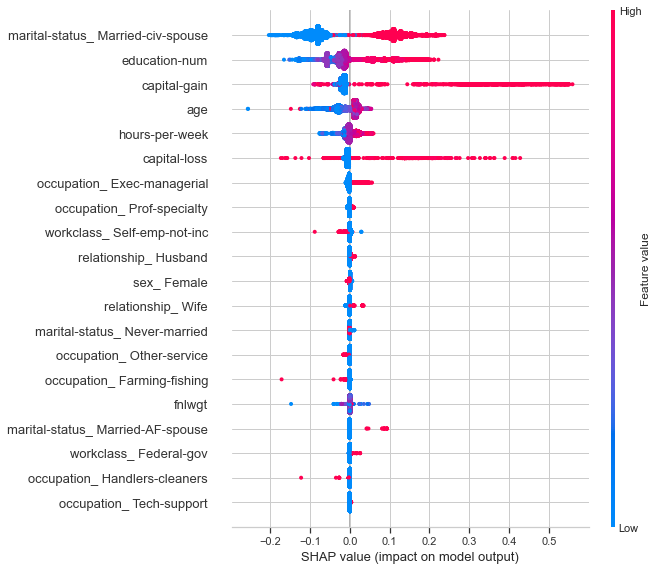

In [54]:
shap.summary_plot(shap_values, X_train)

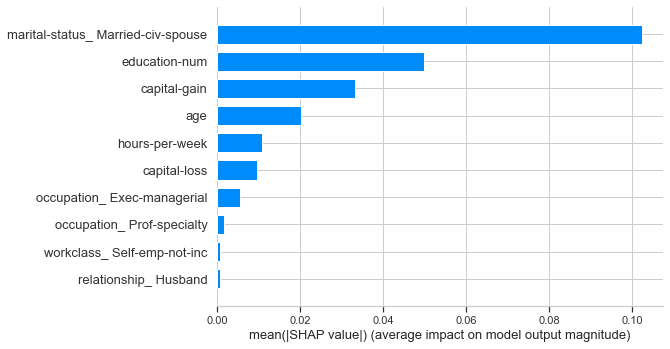

In [55]:
shap.summary_plot(shap_values=shap_values, features=X_train, plot_type='bar', max_display=10)

Наибольшое влияние на целевую переменную оказывают: семейное положение, образование и заработок.